# House Prices: Advanced Regression Techniques
### Predict sales prices and practice feature engineering, RFs, and gradient boosting

1. Import the data

2. Data description



3. Evaluation
The evaluation metric is the RMSLE(root mean squared log error) between the actual and predicted auction prices.



4. Features
The features of this data are given in detail in the data dictionary on kaggle https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data


## 1. Setting up the enviironment

###  Import libraries 

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn import preprocessing

# Pipeline library for Training
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

### Import the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = pd.read_csv('drive/MyDrive/data_science/house-prices-advanced-regression-techniques/train.csv', index_col='Id')
test = pd.read_csv('drive/MyDrive/data_science/house-prices-advanced-regression-techniques/test.csv')

train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 2. Exploratory data analysis

#### Analysing the train and test data

In [5]:
combined_data = pd.concat([train, test], axis=0)
combined_data['Label'] =  combined_data['SalePrice'].isnull()
mapping = {False:'Tain Data',True:'Test Data' }
combined_data['Label'] = combined_data['Label'].map(mapping)

In [6]:
combined_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,Id
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000,1459.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890,2190.000000
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,439.543659,440.766258,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,25.574285,0.761624,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883,421.321334
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000,1461.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000,1825.500000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,467.000000,989.500000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000,2190.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,805.500000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000,2554.500000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000,2919.000000


Some feilds have too many outliers as evidenced by the standard deviation

#### Checking for missing values

In [7]:
print(f'Percent of Nans in Train Data : {round(train.isna().sum().sum()/len(train), 2)}')
print(f'Percent of Nans in Test  Data : {round(test.isna().sum().sum()/len(test), 2)}')

Percent of Nans in Train Data : 4.77
Percent of Nans in Test  Data : 4.8


In [8]:
missing_numeric = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['train', 'test'])
missing_numeric = missing_numeric[(missing_numeric['train']>0) | (missing_numeric['test']>0)]
missing_numeric.sort_values(by=['train', 'test'], ascending=False)

,train,test
PoolQC,1453.0,1456.0
MiscFeature,1406.0,1408.0
Alley,1369.0,1352.0
Fence,1179.0,1169.0
FireplaceQu,690.0,730.0
LotFrontage,259.0,227.0
GarageYrBlt,81.0,78.0
GarageFinish,81.0,78.0
GarageQual,81.0,78.0
GarageCond,81.0,78.0


Values like:
* PoolQC, Alley, MiscFeatures, Fence, FireplaceQu, LotStorage

have a lot of missing values. In as mush as they can be reasons for outliers, they are also responsible for the skewness of the distribution curves. The true outliers will be handled through the use of other feature such as total number of bedroom or area of the place


#### Initial feature engineering and dropping features which do not hold much importance to the sale price

In [9]:
feature_drop = ['PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu', 'LotFrontage', 'GarageYrBlt', 'MoSold', 'YrSold', 
                'LowQualFinSF', 'MiscVal', 'PoolArea']

# These features are nominally encoded, hence to transform them to objects not values which for proper handling during the preprocessing section
train['MSSubClass'].replace({20: 'twenty', 30: 'thitry', 40: 'forty', 45: 'fortyFive', 50: 'fifty', 60: 'sixty', 70: 'seventy', 75: 'seventyFive',
            80: 'eighty', 85: 'eightyFive', 90: 'ninety', 120: 'oneHundredTwenty', 150: 'oneHundredFifty', 160: 'oneHundredSixty',
            180: 'oneHundredEighty', 190: 'oneHundredNinety' }, inplace=True)
train['OverallQual'].replace({1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five', 6: 'six', 7: 'seven', 8: 'eight', 9: 'nine', 10: 'ten'}, inplace=True)
train['OverallCond'].replace({1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five', 6: 'six', 7: 'seven', 8: 'eight', 9: 'nine', 10: 'ten'}, inplace=True)

datasets = [train, test]

for df in datasets:
  df.drop(feature_drop, axis=1, inplace=True)
  df.loc[df['Alley'].isnull(), 'Alley'] = 'NoAlley'

  # If a house has no garage, it will have missing value on the 'Garage related' features, so just fill NaNs with 'NoGarage'.
  df.loc[df['GarageCond'].isnull(), 'GarageCond'] = 'NoGarage'
  df.loc[df['GarageQual'].isnull(), 'GarageQual'] = 'NoGarage'
  df.loc[df['GarageType'].isnull(), 'GarageType'] = 'NoGarage'
  df.loc[df['GarageFinish'].isnull(), 'GarageFinish'] = 'NoGarage'
    
  # If a house has no basement, it will have missing value on the 'basement related' features, so just fill NaNs with 'NoBsmt'.    
  df.loc[df['BsmtExposure'].isnull(), 'BsmtExposure'] = 'NoBsmt'
  df.loc[df['BsmtFinType2'].isnull(), 'BsmtFinType2'] = 'NoBsmt'
  df.loc[df['BsmtCond'].isnull(), 'BsmtCond'] = 'NoBsmt'
  df.loc[df['BsmtQual'].isnull(), 'BsmtQual'] = 'NoBsmt'
  df.loc[df['BsmtFinType1'].isnull(), 'BsmtFinType1'] = 'NoBsmt'
    
  # Masonry veneer feature: just fill with 'None' if there is no Masonry veneer.    
  df.loc[df['MasVnrType'].isnull(), 'MasVnrType'] = 'None'
  df.loc[df['MasVnrArea'].isnull(), 'MasVnrArea'] = 0
       
train['Electrical'].fillna(train['Electrical'].mode()[0], inplace=True)

test_numeric_missing = ['BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'GarageArea', 'GarageCars', 'TotalBsmtSF']
test_categorical_missing = ['MSZoning', 'Functional', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'SaleType']

for i in test_numeric_missing:
    test[i].fillna(0, inplace=True)
for j in test_categorical_missing:
    test[j].fillna(test[j].mode()[0], inplace=True)

# Check the missing values again for datasets
missing_numeric = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['train', 'test'])
missing_numeric = missing_numeric[(missing_numeric['train']>0) | (missing_numeric['test']>0)]
missing_numeric.sort_values(by=['train', 'test'], ascending=False)

,train,test


### <b>Numetical data analysis</b>

#### Data visualization for continuous data

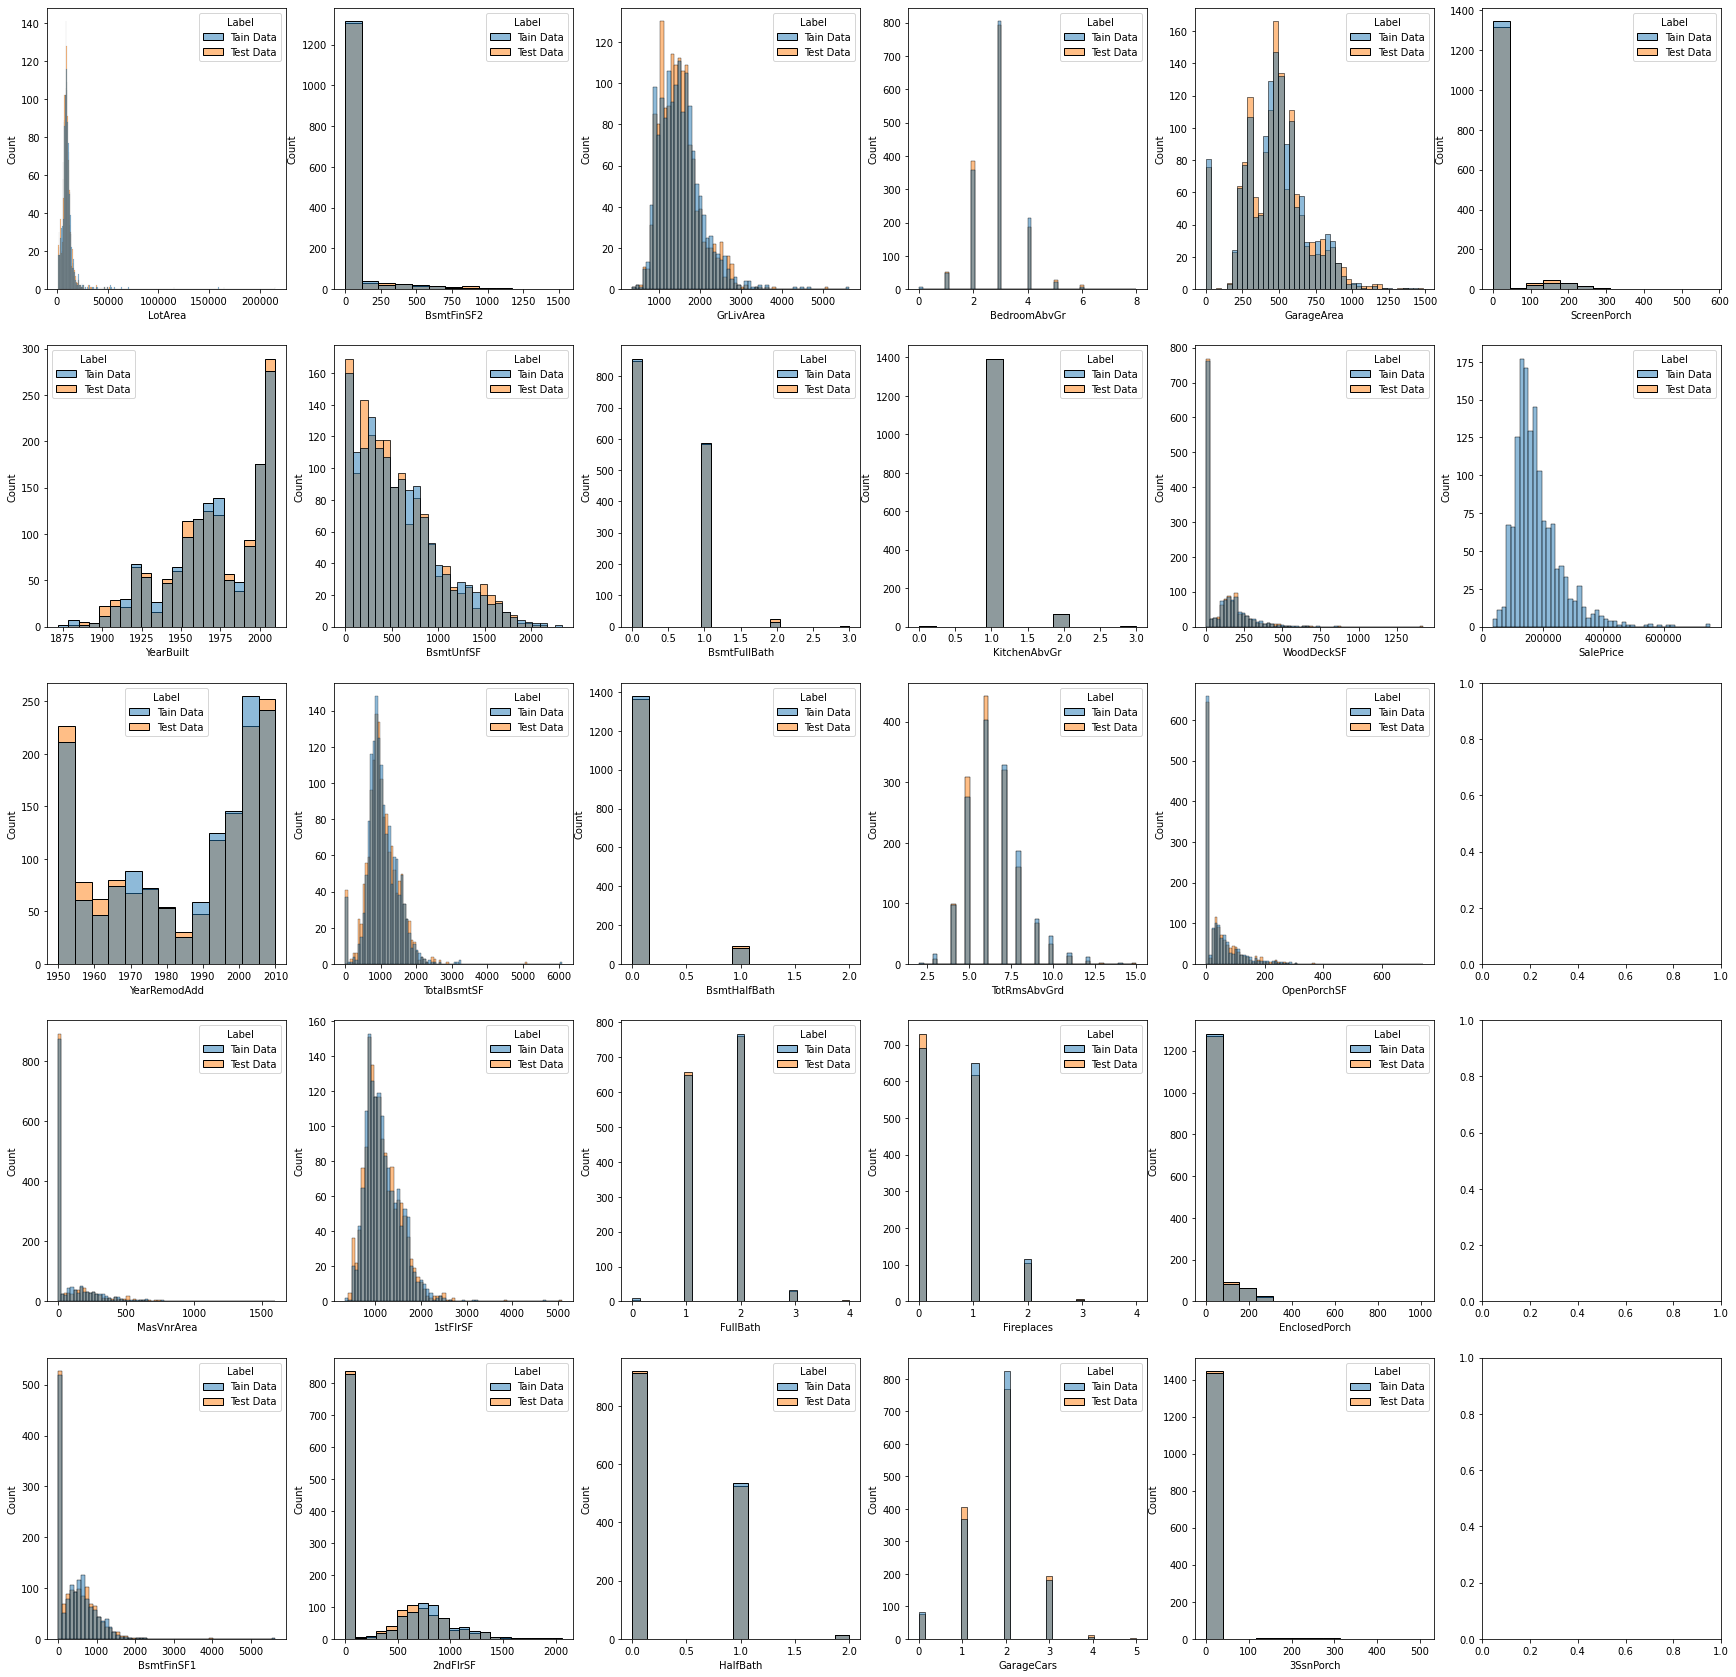

In [11]:
train_data_types = train.dtypes
numerical_data = train_data_types[train_data_types.values != "object"].index

f, axes = plt.subplots(5,6 , figsize=(30, 30), sharex=False)

for i, feature in enumerate(numerical_data):
    sns.histplot(data=combined_data, x = feature, hue="Label",ax=axes[i%5, i//5])

#### The distribution above shows that:

* The distribution of train data and test data are similar for most continous features;

#### Exemining the IQR of numerical data

In [13]:
numerical_cols = [cname for cname in train.columns if train[cname].dtype != "object"]

numerical_train_data = train[numerical_cols].copy()

Q1 = numerical_train_data.quantile(0.25)
Q3 = numerical_train_data.quantile(0.75)
IQR = Q3 - Q1

iqr_comparison = pd.DataFrame(data = {'IQR': IQR, 'Q1': Q1, 'Q3': Q3})
iqr_comparison.sort_values('IQR', ascending=False)

,IQR,Q1,Q3
SalePrice,84025.00,129975.00,214000.00
LotArea,4048.00,7553.50,11601.50
2ndFlrSF,728.00,0.00,728.00
BsmtFinSF1,712.25,0.00,712.25
GrLivArea,647.25,1129.50,1776.75
BsmtUnfSF,585.00,223.00,808.00
1stFlrSF,509.25,882.00,1391.25
TotalBsmtSF,502.50,795.75,1298.25
GarageArea,241.50,334.50,576.00
WoodDeckSF,168.00,0.00,168.00


#### Examining linearity between all numerical data and the target variable

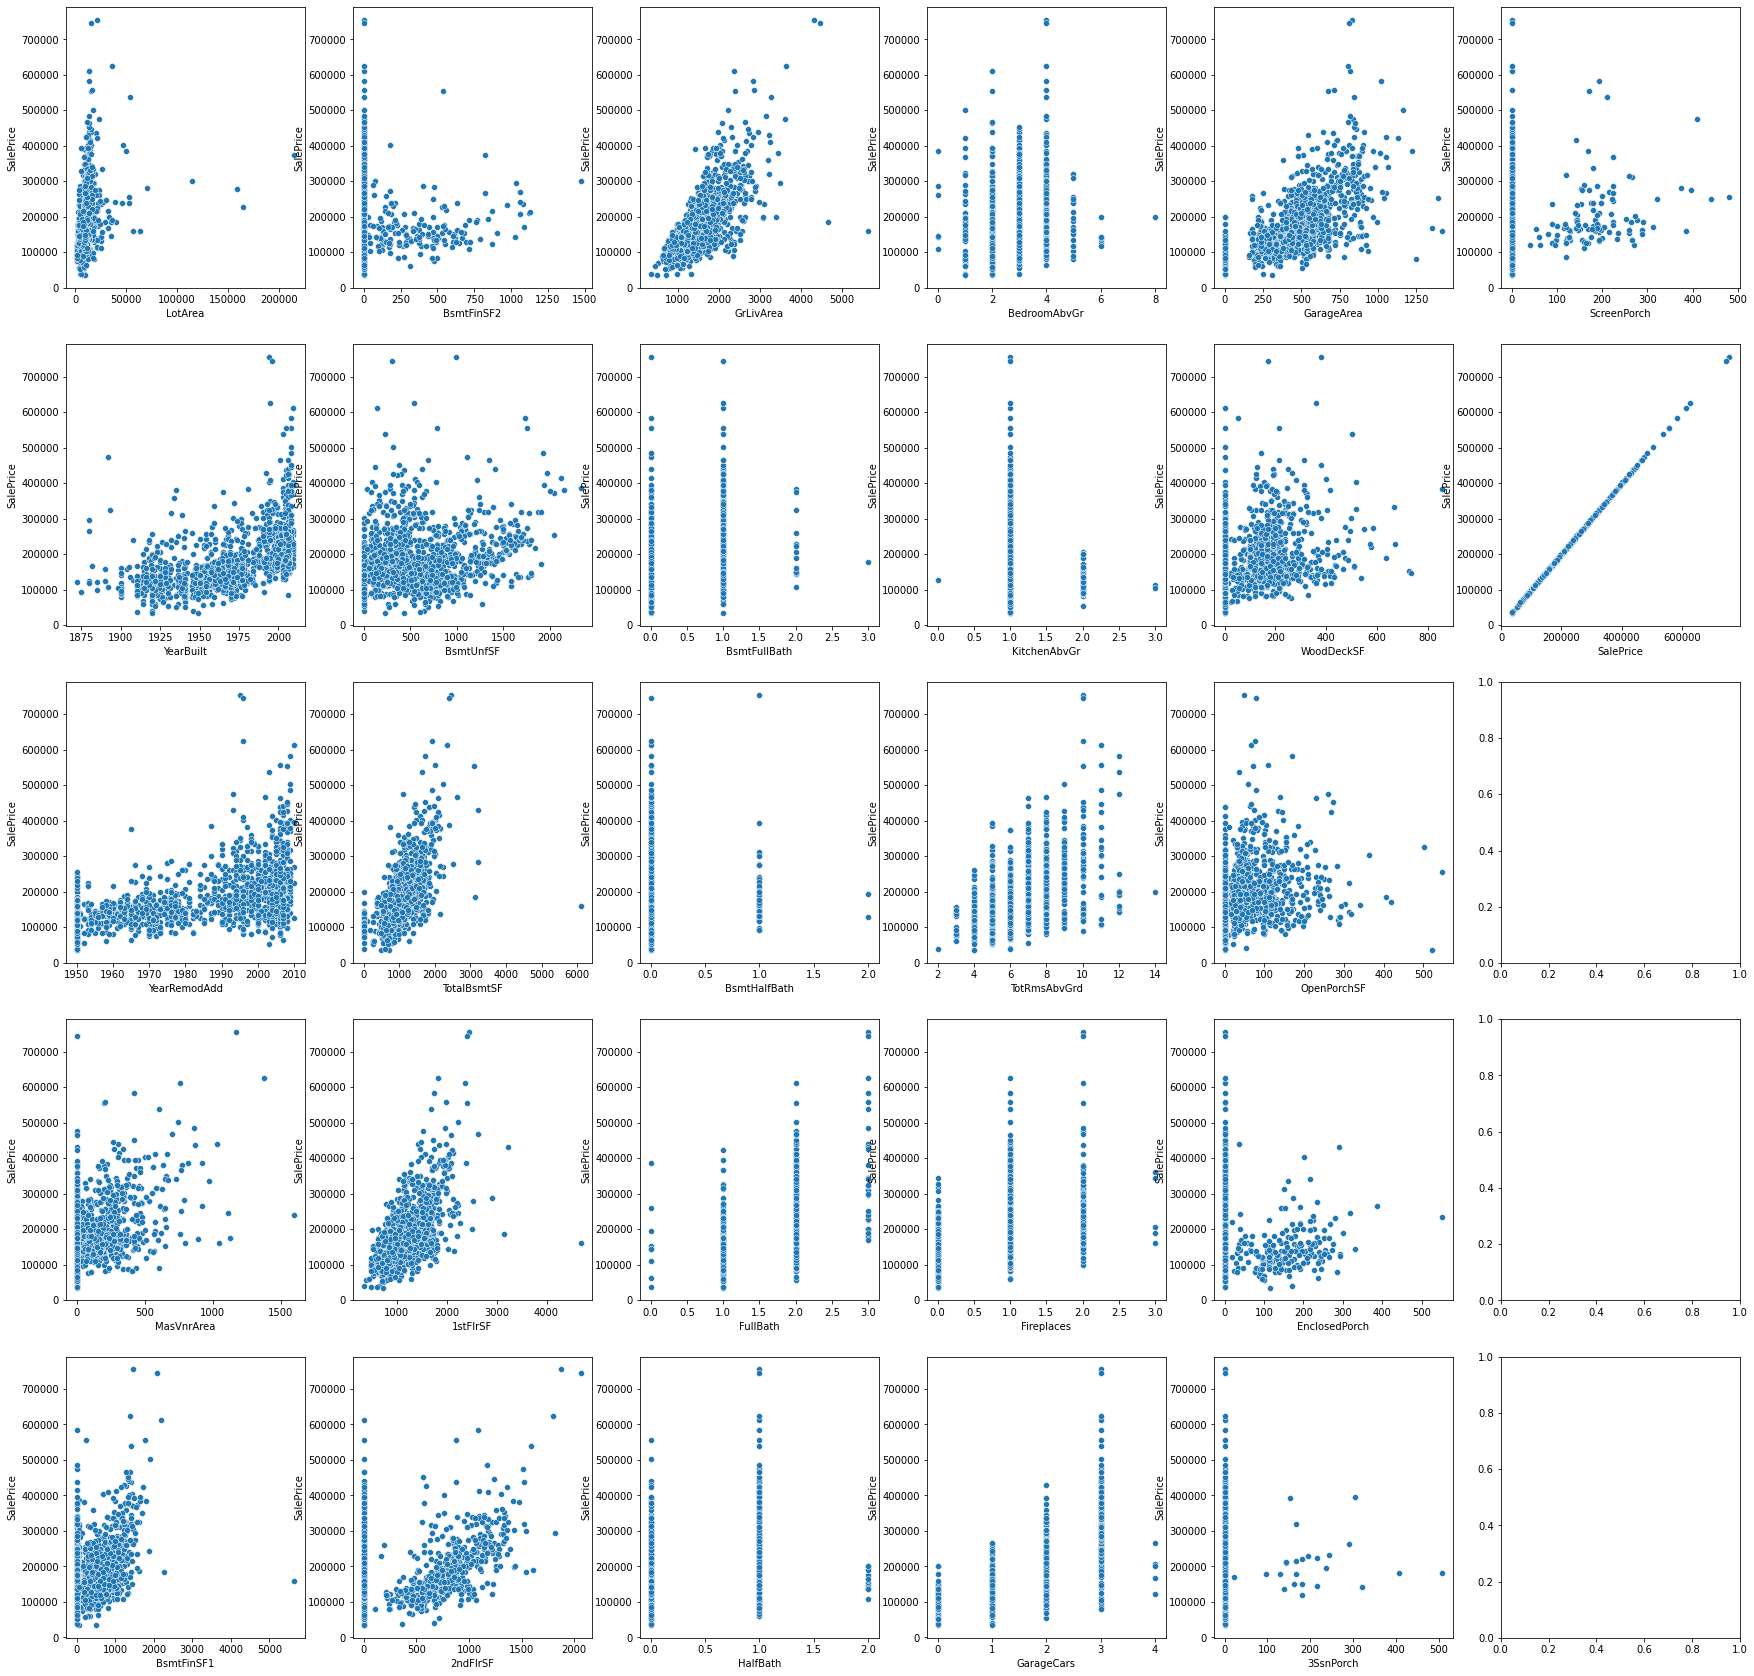

In [14]:
f, axes = plt.subplots(5,6 , figsize=(30, 30), sharex=False)
for i, feature in enumerate(numerical_data):
    sns.scatterplot(data=train, x = feature, y= "SalePrice",ax=axes[i%5, i//5])

##### Consider trasforming data that does not have linear relations with the target variable

#### Skewness of Dependent Feature 'SalePrice'

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64 

Before Transformation Skew:  1.8828757597682129
Log Transformation Skew:  0.12134661989685333


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d964127d0>,
      dtype=object)

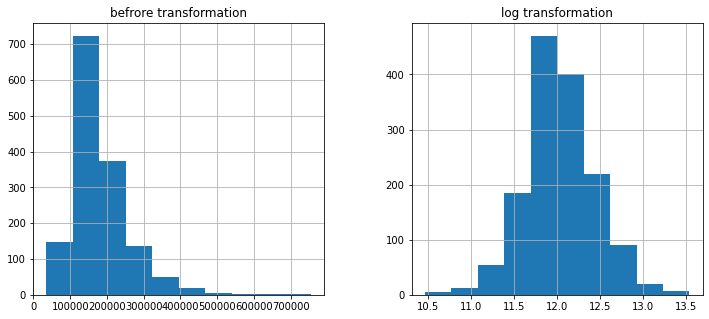

In [15]:
print(train['SalePrice'].describe(), '\n')
print('Before Transformation Skew: ', train['SalePrice'].skew())

train['target'] = np.log1p(train['SalePrice'])
print('Log Transformation Skew: ', train['target'].skew())

plt.rcParams['figure.figsize'] = (12, 5)
target_log_tran = pd.DataFrame({'befrore transformation':train['SalePrice'], 'log transformation': train['target']})
target_log_tran.hist()

#### Comparing the skweness for all features and the target variable

In [16]:
skewness = pd.DataFrame({'Skewness':train.select_dtypes(exclude=[object]).skew()})

print(skewness[skewness['Skewness']>0.8].sort_values(by='Skewness'), '\n')
print(skewness[skewness['Skewness']>0.8].sort_values(by='Skewness').index.tolist())

                Skewness
2ndFlrSF        0.813030
BsmtUnfSF       0.920268
GrLivArea       1.366560
1stFlrSF        1.376757
TotalBsmtSF     1.524255
WoodDeckSF      1.541376
BsmtFinSF1      1.685503
SalePrice       1.882876
OpenPorchSF     2.364342
MasVnrArea      2.677616
EnclosedPorch   3.089872
BsmtHalfBath    4.103403
ScreenPorch     4.122214
BsmtFinSF2      4.255261
KitchenAbvGr    4.488397
3SsnPorch      10.304342
LotArea        12.207688 

['2ndFlrSF', 'BsmtUnfSF', 'GrLivArea', '1stFlrSF', 'TotalBsmtSF', 'WoodDeckSF', 'BsmtFinSF1', 'SalePrice', 'OpenPorchSF', 'MasVnrArea', 'EnclosedPorch', 'BsmtHalfBath', 'ScreenPorch', 'BsmtFinSF2', 'KitchenAbvGr', '3SsnPorch', 'LotArea']


#### Log transformation of all data >= 0.8

In [19]:
skews = ['2ndFlrSF', 'BsmtUnfSF', 'GrLivArea', '1stFlrSF', 'TotalBsmtSF', 'WoodDeckSF', 'BsmtFinSF1', 'OpenPorchSF', 
         'MasVnrArea', 'EnclosedPorch', 'BsmtHalfBath', 'ScreenPorch', 'BsmtFinSF2', 'KitchenAbvGr', '3SsnPorch', 'LotArea']
for df in datasets:
    for s in skews:
        df[s] = np.log1p(df[s])

#### Investigating data correlations using heatmaps

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 <a list of 18 Text major ticklabel objects>)

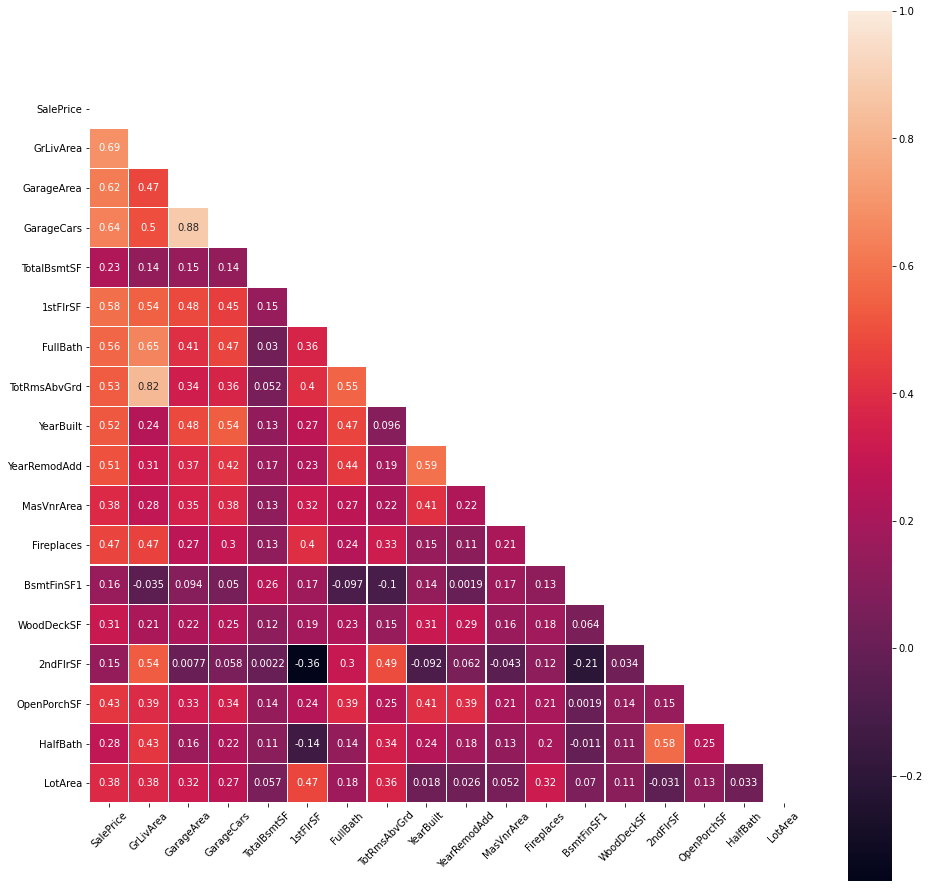

In [21]:
numeric_data = train[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 
                             'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1',
                            'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'HalfBath', 'LotArea', 'BsmtFullBath', 'BsmtUnfSF']]

training_corr = numeric_data.corr()
plt.figure(figsize=(16, 16))
mask = np.zeros_like(training_corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(training_corr, vmax=1, square=True, annot=True, mask=mask, cbar=True, linewidths=0.1)
plt.xticks(rotation=45)

In [22]:
# Top 10 correlated features vs. SalePrice
correlations = numeric_data.corr(method='spearman')['SalePrice'].sort_values(ascending=False)
correlations_abs = correlations.abs()
print(correlations_abs.head(11))

SalePrice       1.000000
GrLivArea       0.731310
GarageCars      0.690711
YearBuilt       0.652682
GarageArea      0.649379
FullBath        0.635957
TotalBsmtSF     0.602725
1stFlrSF        0.575408
YearRemodAdd    0.571159
TotRmsAbvGrd    0.532586
Fireplaces      0.519247
Name: SalePrice, dtype: float64


OverallQual is the only series with a high correlation and sensible so as the state of the house has a largeer waight on the price f a property, followed by GrLivArea.

###  <b>Catagorical Variables</b>

#### Distribution Comparison -

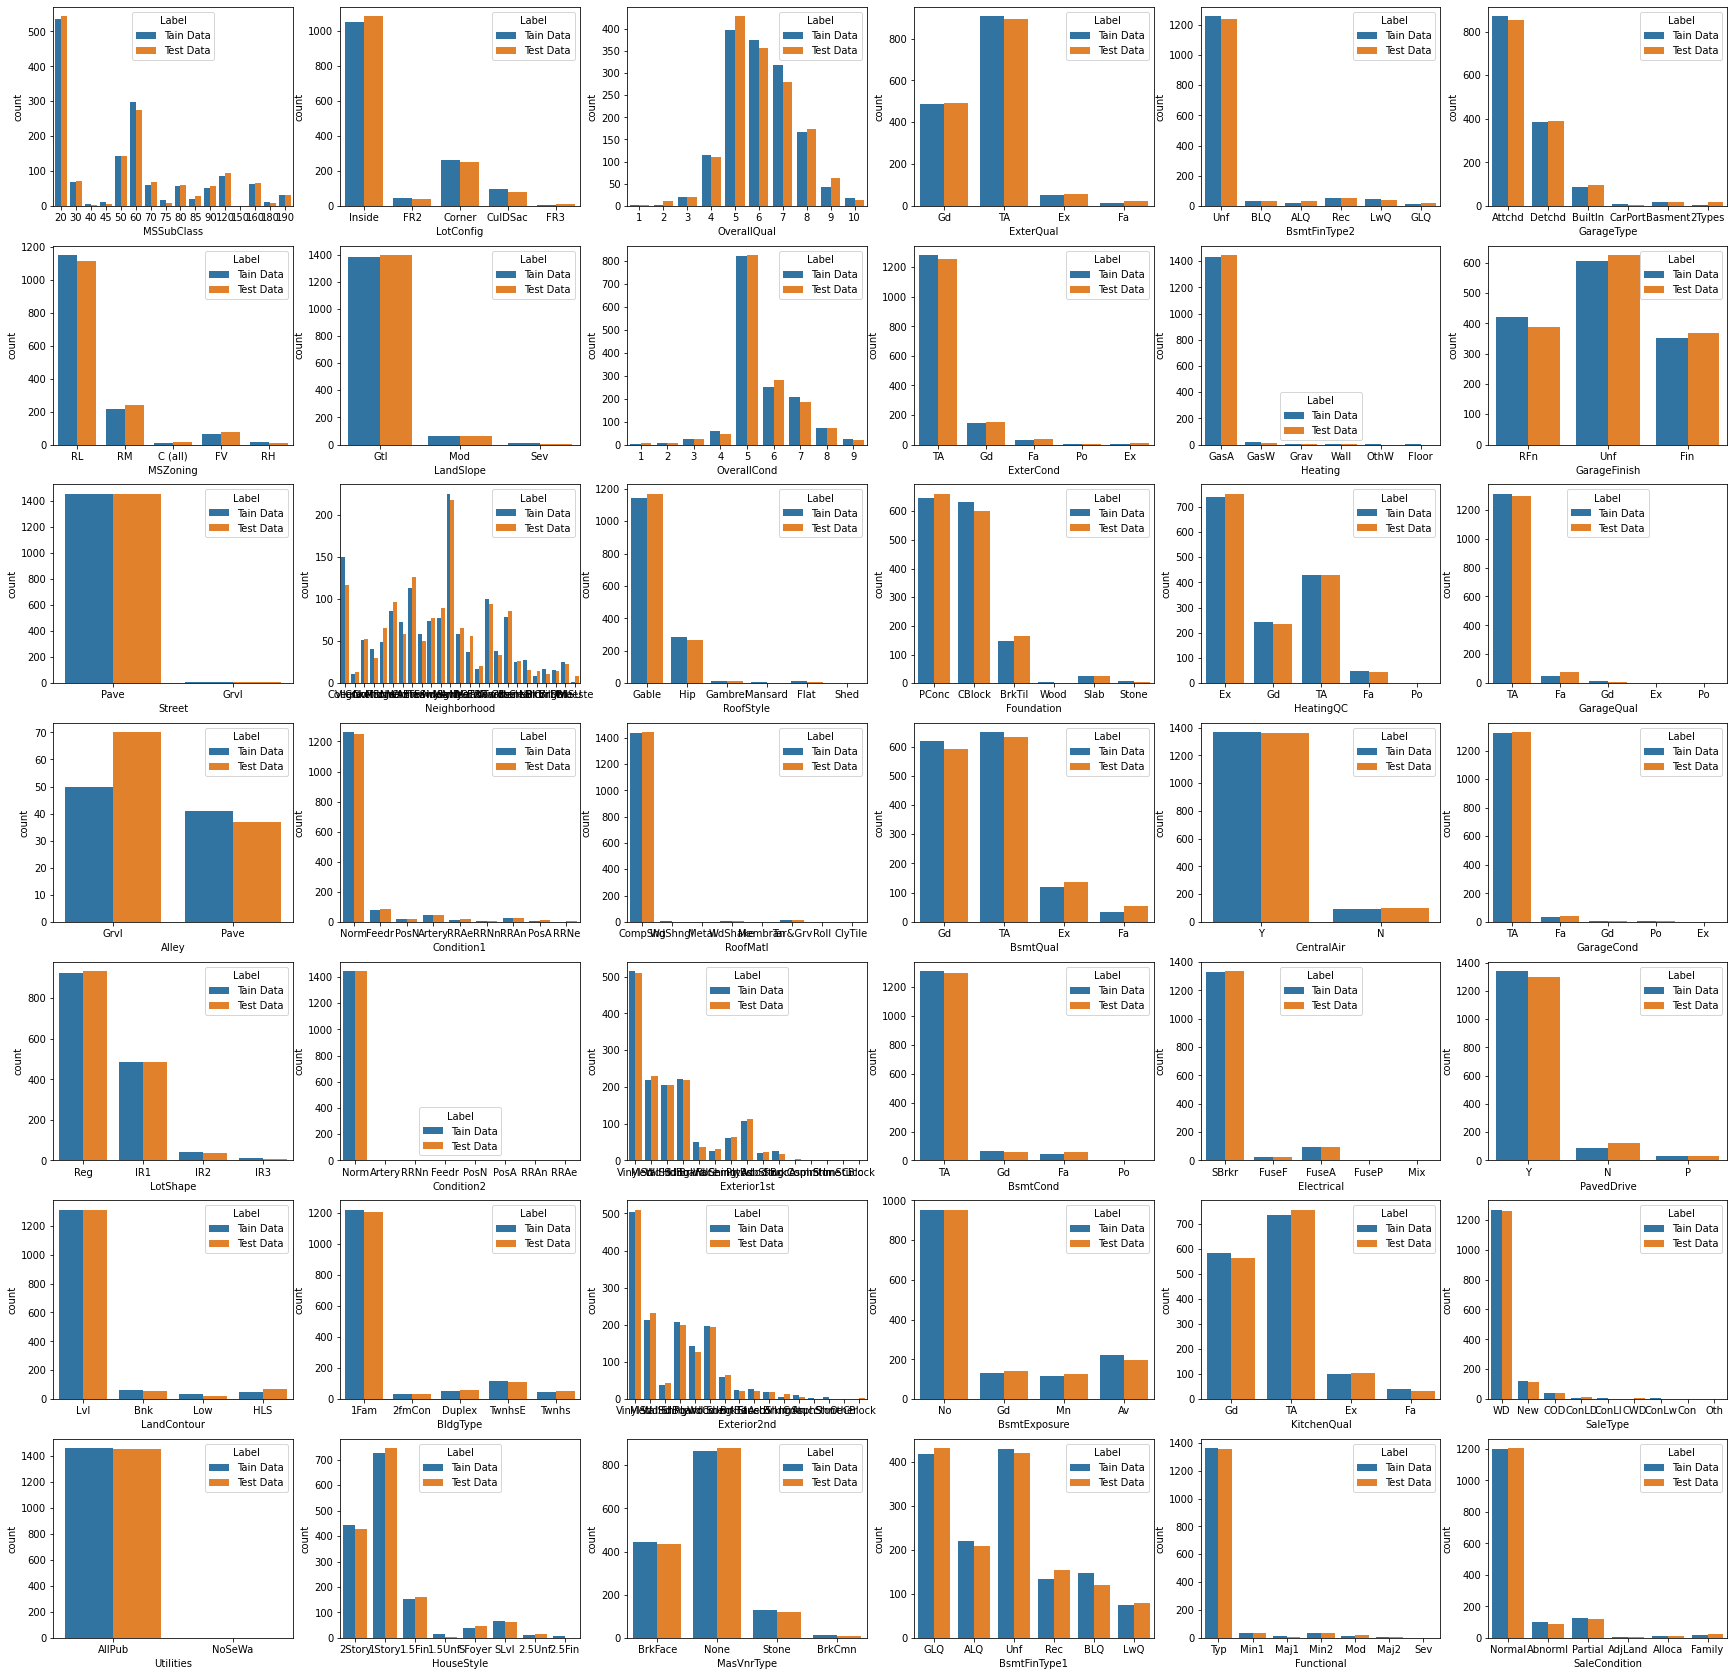

In [23]:
categorical_data = train_data_types[train_data_types.values == 'object'].index
f, axes = plt.subplots(7,6, figsize=(30, 30), sharex=False)
for i, feature in enumerate(categorical_data):
  sns.countplot(data = combined_data, x = feature, hue="Label",ax=axes[i%7, i//7])

#### Investigating the spread of categorical the data using the box and whisker plots

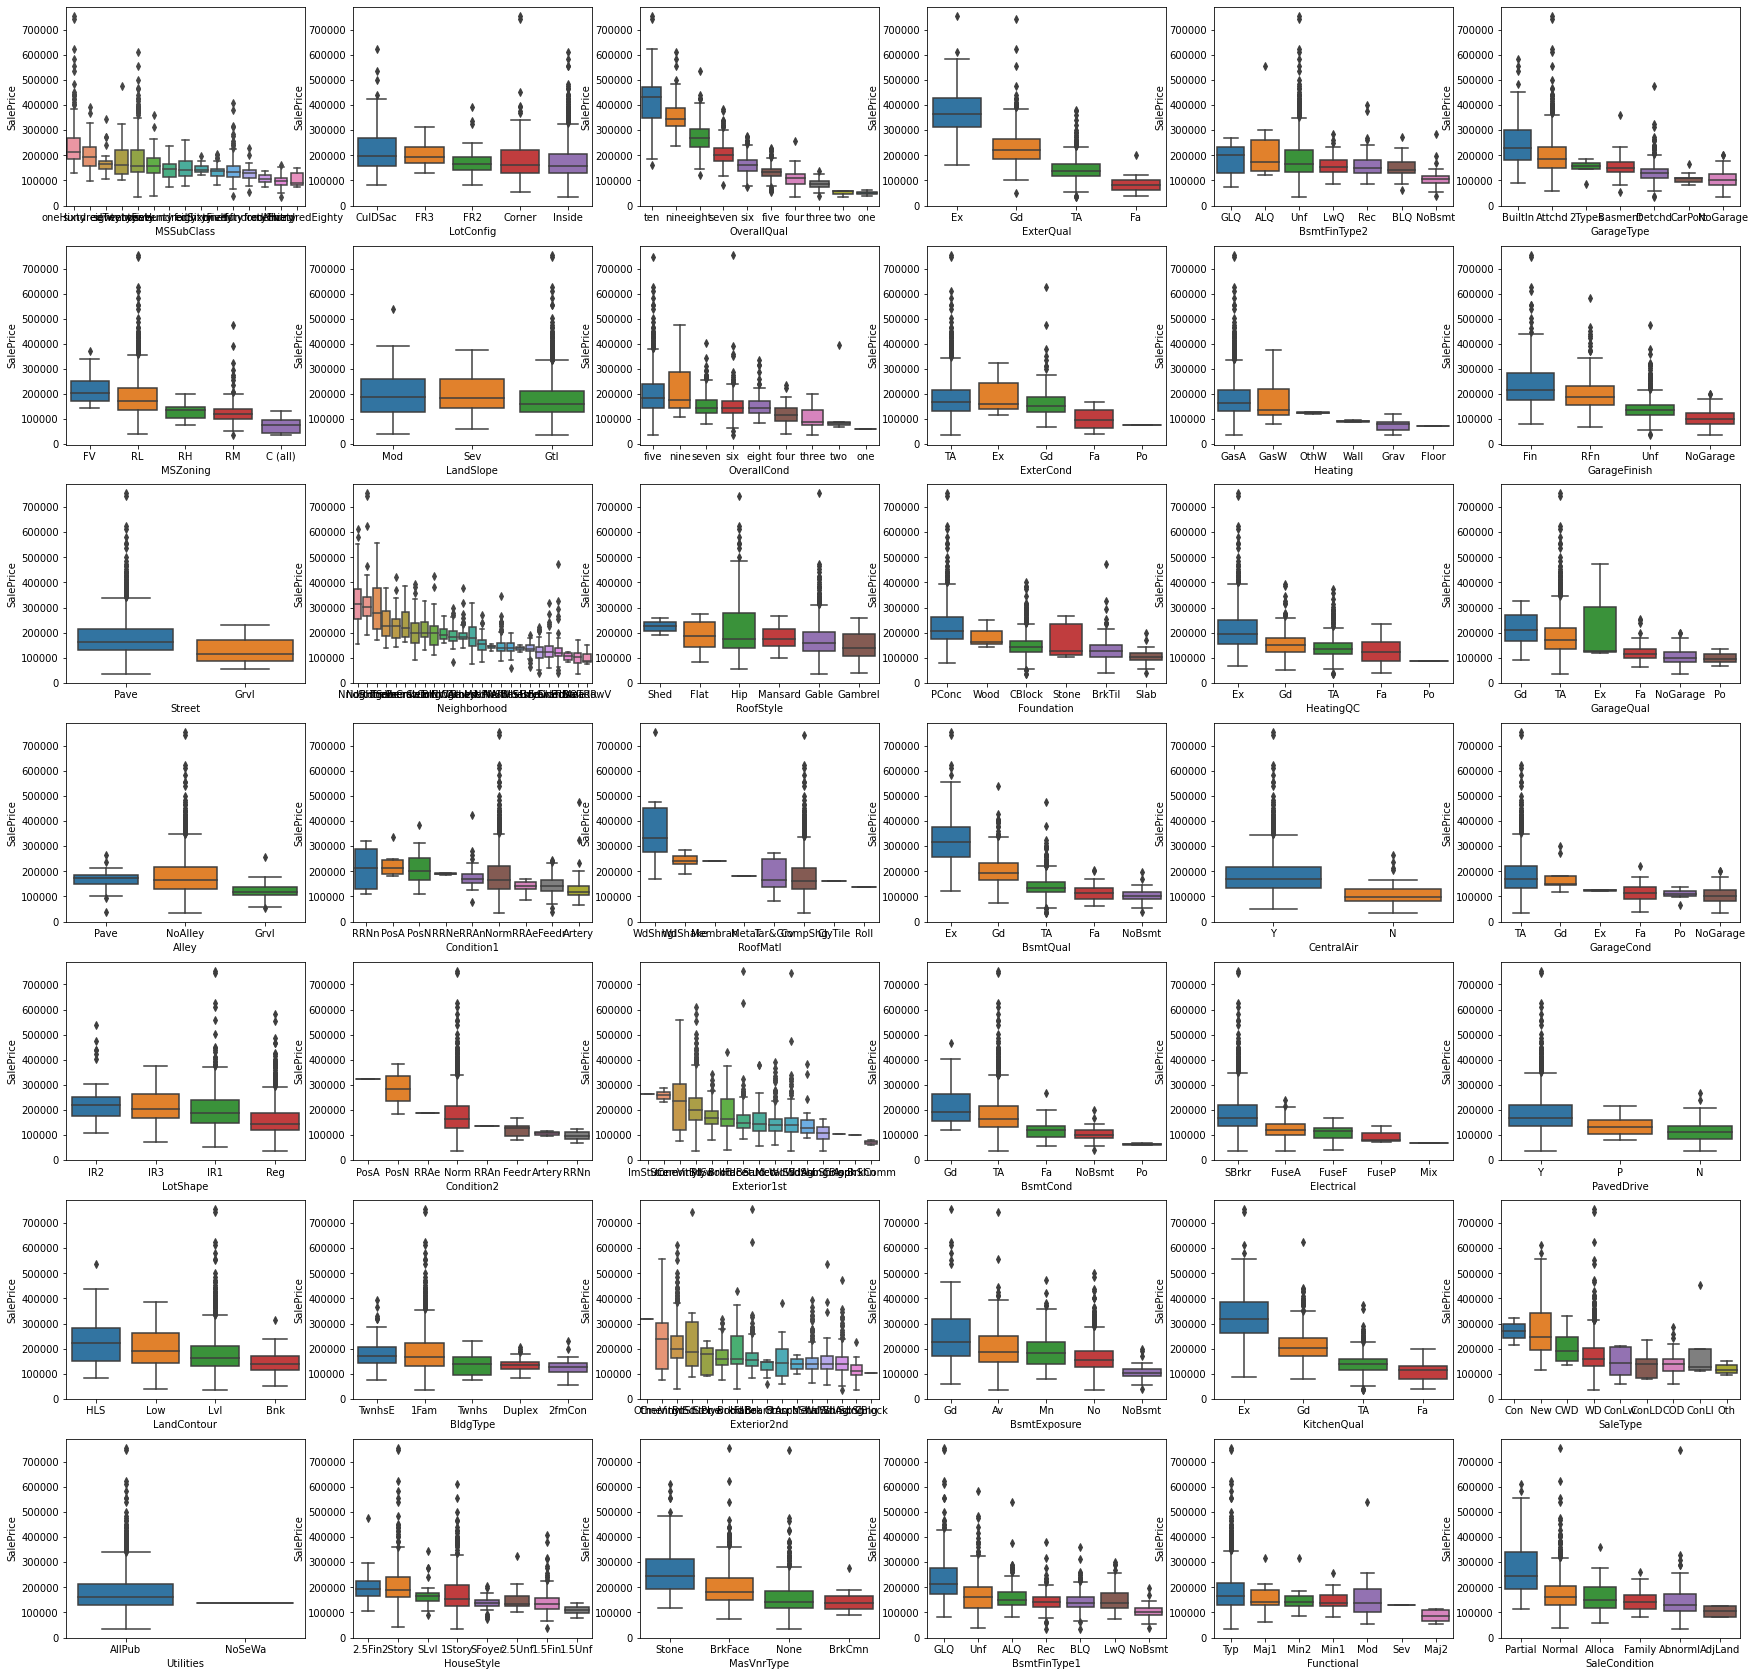

In [24]:
f, axes = plt.subplots(7,6 , figsize=(30, 30), sharex=False)
for i, feature in enumerate(categorical_data):
    sort_list = sorted(train.groupby(feature)['SalePrice'].median().items(), key= lambda x:x[1], reverse = True)
    order_list = [x[0] for x in sort_list ]
    sns.boxplot(data = train, x = feature, y = 'SalePrice', order=order_list, ax=axes[i%7, i//7])
plt.show()

 - sale prices for 'Fa' & 'Po' in 'HeatingQC', 'FireplaceQu', 'GarageQual' and 'GarageCond' are similar, so we may consider go ahead and combine the items.

#### Removing the outliers

In [25]:
index_remove = train[train['GrLivArea'] > 8.5].index.tolist()+train[train['GarageArea'] > 1200].index.tolist()+train[train['TotalBsmtSF'] > 8.2].index.tolist()+train[train['BsmtFinSF1'] > 8].index.tolist()
index_remove = list(set(index_remove))  # remove duplicate values
index_remove.append(523)
print(index_remove)          

train = train.drop(train.index[index_remove], axis=0)
train = train[train['SalePrice'] <=550000]

[1062, 582, 1191, 1299, 826, 523]


#### Creating dummy variables

In [26]:
one_hot_encoded = pd.get_dummies(categorical_data)
one_hot_encoded.head()

,Alley,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,Electrical,ExterCond,ExterQual,Exterior1st,Exterior2nd,Foundation,Functional,GarageCond,GarageFinish,GarageQual,GarageType,Heating,HeatingQC,HouseStyle,KitchenQual,LandContour,LandSlope,LotConfig,LotShape,MSSubClass,MSZoning,MasVnrType,Neighborhood,OverallCond,OverallQual,PavedDrive,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
train = train.drop(categorical_data,axis = 1)

In [28]:
train = train.join(one_hot_encoded)
print(train.columns)

Index(['LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'SalePrice', 'target',
       'Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd',
       'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual',
       'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual',
       'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSSubClass',
       'MSZoning', 'MasVnrType', 'Neighborhood', 'OverallCond', 'OverallQual',
       'PavedDrive', 'RoofMatl', 'Ro

#### Find and Drop duplicates before building the model

In [29]:
# occurrence based on all columns 
duplicate = train[train.duplicated()] 
  
print("Duplicate Rows :") 
duplicate 

Duplicate Rows :


,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,SalePrice,target,Alley,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,Electrical,ExterCond,ExterQual,Exterior1st,Exterior2nd,Foundation,Functional,GarageCond,GarageFinish,GarageQual,GarageType,Heating,HeatingQC,HouseStyle,KitchenQual,LandContour,LandSlope,LotConfig,LotShape,MSSubClass,MSZoning,MasVnrType,Neighborhood,OverallCond,OverallQual,PavedDrive,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [30]:
# dropping duplicate values 
train.drop_duplicates(keep=False,inplace=True) 

## 3. <b>Model building</b>

In [31]:
y = train.SalePrice
train.drop(['SalePrice'], axis=1, inplace=True)

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(train, y, train_size=0.8, test_size=0.2, random_state=42)

In [41]:
params = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7],
        'min_child_weight': [3, 5, 7, 9],
        'subsample': [0.6, 0.7, 0.8, 0.9],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
        'n_estimators' : [1000],
        'objective': ['reg:squarederror']
}

# Set param to output of cross-validation
xgbr = XGBRegressor(
    colsample_bytree= 0.6, 
    learning_rate= 0.01,
    max_depth= 7, 
    min_child_weight= 9, 
    n_estimators=1000, 
    objective='reg:squarederror', 
    subsample= 0.6,
    random_state=42,
    seed=42)

xgbr.fit(X_train, y_train, early_stopping_rounds=5, 
         eval_set=[(X_valid, y_valid)], verbose=False)

y_pred_xgb = xgbr.predict(X_valid)


print("Root Mean squared error: " +  str(math.sqrt(mean_squared_error(y_valid,y_pred_xgb))))



Root Mean squared error: 8021.888038035194


In [40]:
np.isnan(y_pred_xgb)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,